# Import packages

In [ ]:
import glob
import os
from pathlib import Path
from librosa import feature
import pandas as pd
import librosa
import datetime
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
# import scikitplot as skplt
import librosa.display
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import soundfile as sf
from sklearn.svm import SVR


from tensorflow.keras import Sequential, Input, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalMaxPooling1D 
import tensorflow as tf
from keras.layers import Flatten
from sklearn.model_selection import KFold

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [ ]:
def split(filez):
    """
    split the audio files into 5 sec chunks
    """
    split_into = 5
    samples_splitted = []
    current_step = 0
    i=0
    X,sample_rate = librosa.load(filez, res_type="kaiser_best" )
    while current_step < len(X):
        samples_splitted.append(X[current_step: split_into * sample_rate ])
        sf.write(f"set22-{i} outfile.wav", samples_splitted[i], sample_rate)
        current_step = split_into * sample_rate
        i+=1

        split_into += 5

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape(y_true, y_pred):
    return (K.mean((K.abs(y_pred - y_true))/y_true) * 100)
     

# Load all the splitted audio files

In [ ]:
path= '/content/drive/MyDrive/splitaudio/'
files = os.listdir(path)
audiofile = []
for filename in glob.glob(os.path.join(path, '*.wav')):
    data, samplerate = librosa.load(filename, res_type='kaiser_best')
    audiofile.append(data)
print(len(audiofile))

1595


### Data Visualization

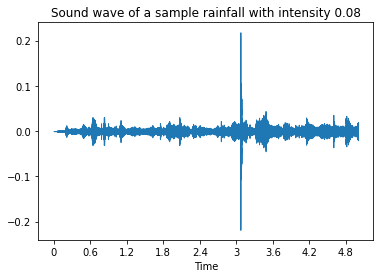

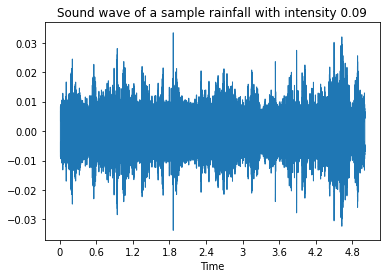

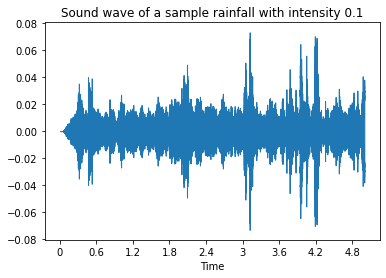

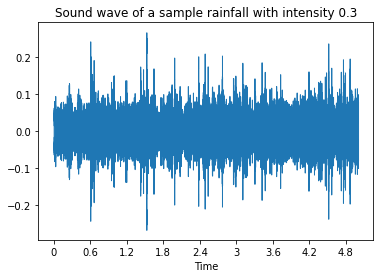

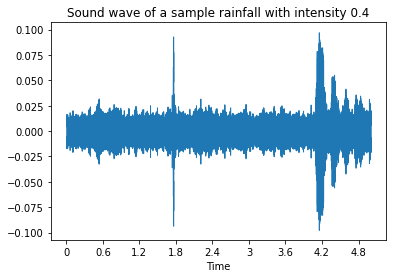

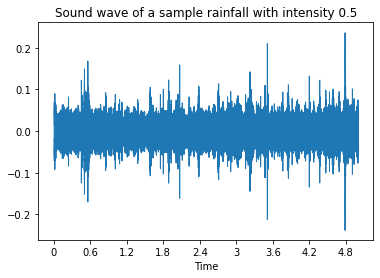

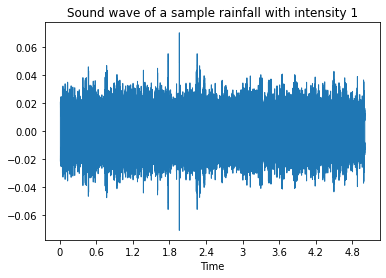

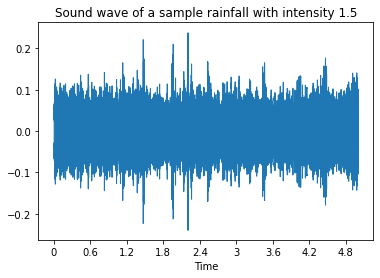

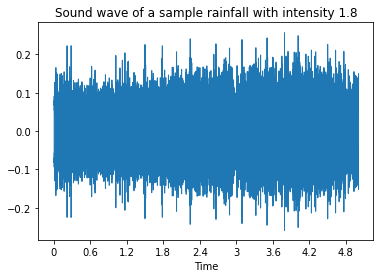

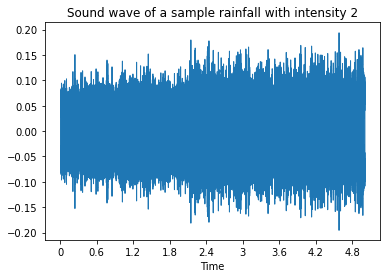

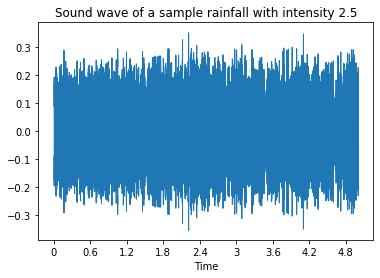

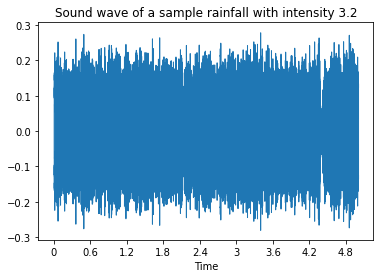

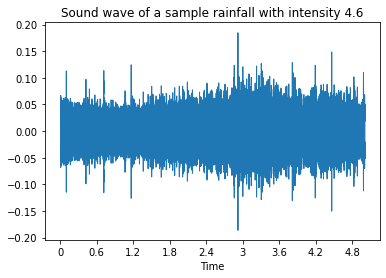

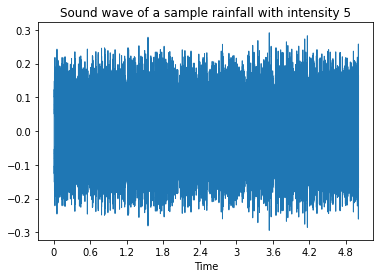

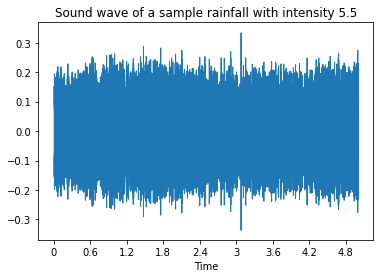

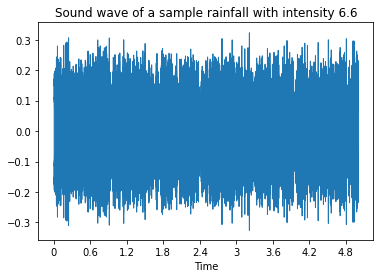

In [ ]:
import matplotlib.pyplot as plt
from librosa import display

labels_of_each_samples = ["0.08", "0.09", "0.1", "0.3", "0.4", "0.5", "1", "1.5", "1.8", "2", "2.5", "3.2", "4.6", "5", "5.5", "6.6"]
sample_from_each_lables = ["9-0", "6-12", "1-0", "19-11", "5-26", "16-20", "3-16", "18-33", "7-21", "2-22", "10-19", "15-1", "11-1", "14-10", "13-56", "12-24"]

for sample_index in range(len(sample_from_each_lables)):
  y, sr = librosa.load(f"/content/drive/MyDrive/splitaudio/set{sample_from_each_lables[sample_index]} outfile.wav")
  fig, ax = plt.subplots(nrows=1, sharex=True)
  
  display.waveshow(y, sr=sr, ax=ax)
  ax.set(title=f'Sound wave of a sample rainfall with intensity {labels_of_each_samples[sample_index]}')
  ax.label_outer()

In [ ]:
S = librosa.amplitude_to_db(abs(X))

In [ ]:
NO_PER_LABEL =NO_PER_LABEL =[65, 60, 60, 60, 61, 60, 60, 60, 60, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 60, 61, 60, 60]
readings = [0.1, 2.5, 4.6, 6.6, 5.5, 5, 3.2, 0.5, 0.1, 1.5, 0.3, 2, 3.5, 3.5, 1.5, 3.5, 5.5, 5.5, 1.5, 1, 1, 0.4, 0.09, 1.8, 0.5, 0.08]
label_list=[]
for i,reading in zip(NO_PER_LABEL, readings):
    count=0
    while count <= i:
        label_list.append(reading)
        count+=1
print(len(label_list))

1595


In [ ]:
import matplotlib.pyplot as plt
from librosa import display
plt.figure(figsize=(14, 5))

# labels_of_each_samples = ["0.08", "0.09", "0.1", "0.3", "0.4", "0.5", "1", "1.5", "1.8", "2", "2.5", "3.2", "4.6", "5", "5.5", "6.6"]
# sample_from_each_lables = ["9-0", "6-12", "1-0", "19-11", "5-26", "16-20", "3-16", "18-33", "7-21", "2-22", "10-19", "15-1", "11-1", "14-10", "13-56", "12-24"]
labels_of_each_samples = ["0.08", "6.6"]
sample_from_each_lables = ["9-0", "12-24"]

for sample_index in range(len(sample_from_each_lables)):
  y, sr = librosa.load(f"/content/drive/MyDrive/splitaudio/set{sample_from_each_lables[sample_index]} outfile.wav")
  # fig, ax = plt.subplots(nrows=1, sharex=True)
  # display.waveshow(librosa.feature.zero_crossing_rate(y), sr=sr, ax=ax)
  # display.specshow(np.correlate(y, y, mode='full')[len(y)-1:], sr=22050, x_axis='time') 
  # r = np.correlate(y, y, mode='full')[len(y)-1:]
  r = librosa.autocorrelate(y, max_size=100)

  plt.plot(r[:100], label=f'ACR of a sample rainfall with intensity {labels_of_each_samples[sample_index]}')
  plt.xlabel('Lag (samples)')
  plt.xlim(0, 100)
plt.legend()
plt.title('ACR plots')
  # ax.label_outer()

# r = numpy.correlate(x, x, mode='full')[len(x)-1:]


### Feature Extraction

In [ ]:
# extract 12  mfccs for each 5sec audio file
path= '/content/drive/MyDrive/splitaudio/'
files = os.listdir(path)
mfccs = []
for filename in glob.glob(os.path.join(path, '*.wav')):
    data, samplerate = librosa.load(filename, res_type='kaiser_best')
    mfccs.append(np.mean(librosa.feature.mfcc(y=data, sr=22050, n_mfcc=21)[1:].T,axis=0))
print(len(mfccs))

# get the labels
csv_file = pd.read_csv("/content/drive/MyDrive/splitaudio/AI4AfricaSWS.csv")
labels = csv_file["rain intensity(mm/5mins)"]
# save the mfccs and labels to npz
np.savez_compressed('rain_dataset', mfcc=np.array(mfccs), label=np.array(labels))


1595


### Data Aggregation 

###### load the npz file 

In [ ]:
rain_dataset = np.load('/content/rain_dataset.npz')
print(len(rain_dataset['mfcc']))
X = rain_dataset["mfcc"]
X= X.flatten() 
X.shape

1595


(31900,)

In [ ]:
# pick chunks of 2 minutes =  ( 12* 24)
from itertools import islice
def combine_5_seconds_to_2_mins(it, size):
    it = iter(it)
    return list(iter(lambda: tuple(islice(it, size)), ()))

combined_data = combine_5_seconds_to_2_mins(X, 480)
label_list = combine_5_seconds_to_2_mins(rain_dataset['label'], 24)

new_labels_for_combined_data = []
for label in label_list:
    new_labels_for_combined_data.append(label[0])
data = np.array(combined_data, dtype=object)

In [ ]:
len(combined_data)

67

In [ ]:
combined_data =[]
for dat in data[:-1]:
    combined_data.append(np.array(dat, dtype=np.float64))
combined_data = np.array(combined_data)

### Scaling of data

In [ ]:
scaler = StandardScaler()
# good_list_scaled = (scaler.fit_transform(good_list))
combined_data = (scaler.fit_transform(combined_data))


### No Recombination of examples\

In [ ]:
rain_dataset = np.load('/content/rain_dataset.npz')
print(len(rain_dataset['mfcc']))
X = rain_dataset["mfcc"]
Y = rain_dataset["label"]
print(len(Y))
scaler = StandardScaler()
# good_list_scaled = (scaler.fit_transform(good_list))
combined_data = (scaler.fit_transform(X))

1595
1595


Baseline Model Development (SVR)

In [ ]:

X = combined_data
# Y =  new_labels_for_combined_data[:-1]
# Splitting dataset into train and test set

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size = 0.2, random_state = 0, shuffle=True)

model = SVR(kernel="poly")

model.fit( X_train, Y_train )

Y_pred = model.predict( X_test )

mse = mean_absolute_percentage_error(Y_test, Y_pred) * 100 ##( |ypred - ytrue|/ytrue * 100)

print(' The Mean absolute percentage Error is ->', mse, '%')

 The Mean absolute percentage Error is -> 185.3133257083266 %


In [ ]:
X_train[0].shape

(20,)

### CNN Model

In [ ]:
X_train = X_train.reshape( (len(X_train), 20, 1))
X_test = X_test.reshape( (len(X_test), 20, 1))
X = X.reshape( (len(X), 20, 1))

In [ ]:
hidden_activation_function = 'relu'
output_activation_function = 'linear'
optimize = 'adam'
kfold = KFold(n_splits=5, shuffle=True)
mapes = []
for train, test in kfold.split(X, Y):
  print(train)
  model = Sequential()
  model.add(Conv1D(filters=72, kernel_size=3, activation=hidden_activation_function, input_shape=(X[0].shape[0],X[0].shape[1])))
  model.add(Conv1D(filters=36, kernel_size=3, activation=hidden_activation_function))

  # # model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=4))
  # model.add(Flatten())
  model.add(Dense(6, activation=hidden_activation_function))
  # model.add(Dense(1,  kernel_initializer='normal', activation=hidden_activation_function)),
  model.add(Dense(3,  kernel_initializer='normal', activation=hidden_activation_function)),
  model.add(Dense(1, activation=output_activation_function))
  model.compile(loss=mape, optimizer=tf.keras.optimizers.Adam(learning_rate= 0.02,),)
  history = model.fit(np.array(X)[train.astype(int)], np.array(Y)[train.astype(int)], validation_split = 0.2, epochs=200,)


  # Predict test set labels
  y_pred = model.predict(X[test])

  # print( " CNN Predicted values ", np.round( Y_pred[:30], 2 ) )

  y_pred =y_pred[:, 0] 
  # print( "Real values	 ", Y_test[:30] )

  mse = mean_absolute_percentage_error(np.array(Y)[test], y_pred) *100 ##( |ypred - ytrue|/ytrue * 100)
  mapes.append(mse)


print(' The mean absolute percentage Error is ->', np.array(mapes).mean(), '%')

model.summary()
with open("report.txt", "a") as f:
  model.summary(print_fn=lambda x: f.write(x + '\n'))
  f.write('Hidden Layer Activation Function :' +str(hidden_activation_function)+ '\n')
  f.write('Output Layer Activation Function :' +str(output_activation_function)+ '\n')
  f.write('Optimizer Function :' +str(optimize)+ '\n')
  f.write('The Mean absolute percentage Error is ->' +str(np.array(mapes).mean())+ '%'+ '\n\n\n')
  


[   0    1    3 ... 1592 1593 1594]
Epoch 1/200
32/32 [==============================] - 2s 14ms/step - loss: 90.5219 - val_loss: 57.3710
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 84.7425 - val_loss: 56.7623
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 85.1890 - val_loss: 65.4176
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 85.1798 - val_loss: 71.8069
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 84.8032 - val_loss: 58.3818
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - loss: 84.6592 - val_loss: 59.9183
Epoch 7/200
32/32 [==============================] - 0s 6ms/step - loss: 84.6472 - val_loss: 60.6313
Epoch 8/200
32/32 [==============================] - 0s 6ms/step - loss: 84.6556 - val_loss: 60.6266
Epoch 9/200
32/32 [==============================] - 0s 6ms/step - loss: 84.9915 - val_loss: 57.4496
Epoch 10/200
32/32 [==============================] - 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-22099f80002f>", line 20, in <module>
    history = model.fit(np.array(X)[train.astype(int)], np.array(Y)[train.astype(int)], validation_split = 0.2, epochs=200,)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.8/dist-package

KeyboardInterrupt: ignored

In [ ]:
hidden_activation_function = 'relu'
output_activation_function = 'linear'
optimize = 'adam'

# X_train, X_test, X_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = Sequential()
# model.add(Conv1D(filters=72, kernel_size=3, activation=hidden_activation_function, input_shape=(X_train[0].shape[0],X_train[0].shape[1])))
# model.add(Conv1D(filters=72, kernel_size=3, activation=hidden_activation_function, input_shape=(X_train[0].shape[0],X_train[0].shape[1])))


model.add(Conv1D(filters=36, kernel_size=9, activation=hidden_activation_function, input_shape=(X_train[0].shape[0],X_train[0].shape[1])))
model.add(Conv1D(filters=72, kernel_size=5, activation=hidden_activation_function, input_shape=(X_train[0].shape[0],X_train[0].shape[1])))

model.add(Conv1D(filters=128, kernel_size=3, activation=hidden_activation_function))
# model.add(Conv1D(filters=256, kernel_size=3, activation=hidden_activation_function))


# model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation=hidden_activation_function))

model.add(Dense(16, activation=hidden_activation_function))
# model.add(Dense(8, activation=hidden_activation_function))

# model.add(Dense(1,  kernel_initializer='normal', activation=hidden_activation_function)),
model.add(Dense(8,  kernel_initializer='normal', activation=hidden_activation_function)),
model.add(Dense(1, activation=output_activation_function))
model.compile(loss=mape, optimizer=tf.keras.optimizers.Adam(learning_rate= 0.002,),)
history = model.fit(X_train, Y_train, validation_split = 0.2, epochs=150,)


# Predict test set labels
y_pred = model.predict(X_test)

# print( " CNN Predicted values ", np.round( Y_pred[:30], 2 ) )

y_pred =y_pred[:, 0] 
# print( "Real values	 ", Y_test[:30] )

mse = mean_absolute_percentage_error(Y_test, y_pred) *100 ##( |ypred - ytrue|/ytrue * 100)



print(' The mean absolute percentage Error is ->', mse, '%')

model.summary()
with open("report.txt", "a") as f:
  model.summary(print_fn=lambda x: f.write(x + '\n'))
  f.write('Hidden Layer Activation Function :' +str(hidden_activation_function)+ '\n')
  f.write('Output Layer Activation Function :' +str(output_activation_function)+ '\n')
  f.write('Optimizer Function :' +str(optimize)+ '\n')
  f.write('The Mean absolute percentage Error is ->' +str(mse)+ '%'+ '\n\n\n')
  


Epoch 1/150
32/32 [==============================] - 4s 24ms/step - loss: 80.1289 - val_loss: 75.3640
Epoch 2/150
32/32 [==============================] - 0s 15ms/step - loss: 70.6992 - val_loss: 68.5762
Epoch 3/150
32/32 [==============================] - 0s 15ms/step - loss: 65.1600 - val_loss: 65.8225
Epoch 4/150
32/32 [==============================] - 1s 16ms/step - loss: 60.6161 - val_loss: 57.9887
Epoch 5/150
32/32 [==============================] - 0s 15ms/step - loss: 58.0070 - val_loss: 54.9767
Epoch 6/150
32/32 [==============================] - 0s 15ms/step - loss: 54.1116 - val_loss: 49.9616
Epoch 7/150
32/32 [==============================] - 0s 14ms/step - loss: 51.5223 - val_loss: 49.7915
Epoch 8/150
32/32 [==============================] - 0s 13ms/step - loss: 47.6946 - val_loss: 45.1698
Epoch 9/150
32/32 [==============================] - 0s 14ms/step - loss: 44.0053 - val_loss: 40.4476
Epoch 10/150
32/32 [==============================] - 0s 15ms/step - loss: 42.0278

In [ ]:
X_train[0].shape[0]

20

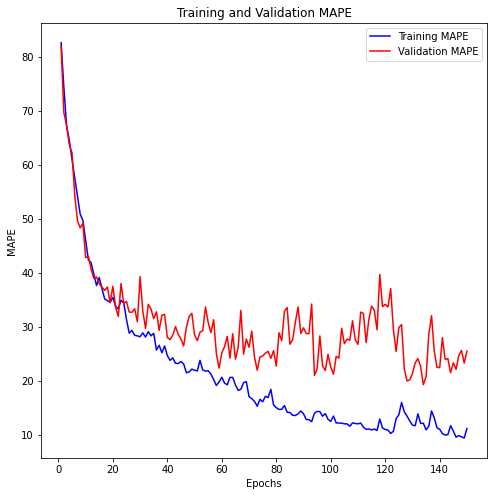

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'b', label='Training MAPE')
plt.plot(epochs, loss_val, 'r', label='Validation MAPE')
plt.title('Training and Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

1/1 [==============================] - 0s 176ms/step
 CNN Predicted values  [1.71 1.79 1.81 1.34 1.15 1.85 1.51 1.81 1.96 1.82 2.11 1.74 2.39 1.63]
Real values	  [5.5, 0.3, 2.0, 0.4, 0.5, 3.5, 1.0, 5.5, 3.5, 2.5, 3.5, 3.5, 3.5, 1.5]
 The Mean absolute percentage Error is -> 91.65724545913065 %


In [ ]:
model.save('./saved_models/baseline_model.h5')


In [ ]:
import os
baseline_model_size = os.path.getsize('./saved_models/baseline_model.h5')

In [ ]:
# Installing with the `--upgrade` flag ensures you'll get the latest version.
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 5.1 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
epochs = 50
batch_size = 32
end_step = 200

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=end_step)
}

pruned_model = prune_low_magnitude(model,**pruning_params)
pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.002,),loss=mape)


In [ ]:
import tempfile
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

In [ ]:
pruned_model.fit(x=X_train,y=np.array(Y_train),epochs=epochs,validation_data=(X_test,np.array(Y_test)),callbacks=callbacks) 


Epoch 1/30
 6/40 [===>..........................] - ETA: 0s - loss: 12.1411  

40/40 [==============================] - 7s 21ms/step - loss: 15.1178 - val_loss: 35.6659
Epoch 2/30
40/40 [==============================] - 1s 13ms/step - loss: 13.4215 - val_loss: 40.0038
Epoch 3/30
40/40 [==============================] - 0s 12ms/step - loss: 47.3261 - val_loss: 65.3827
Epoch 4/30
40/40 [==============================] - 0s 12ms/step - loss: 59.4551 - val_loss: 56.4954
Epoch 5/30
40/40 [==============================] - 0s 12ms/step - loss: 45.4607 - val_loss: 60.7722
Epoch 6/30
40/40 [==============================] - 0s 12ms/step - loss: 41.2905 - val_loss: 49.3129
Epoch 7/30
40/40 [==============================] - 0s 12ms/step - loss: 34.5631 - val_loss: 44.0706
Epoch 8/30
40/40 [==============================] - 0s 12ms/step - loss: 31.4275 - val_loss: 41.8062
Epoch 9/30
40/40 [==============================] - 1s 13ms/step - loss: 29.2171 - val_loss: 41.5042
Epoch 10/30
40/40 [==============================] - 1s 13ms/step - loss: 27.0241 - val_loss: 41.2749


In [ ]:
predictions=pruned_model.predict(X_test)
pruned_rmse = mean_absolute_percentage_error(Y_test, y_pred) *100 ##( |ypred - ytrue|/ytrue * 100)



10/10 [==============================] - 0s 4ms/step


In [ ]:
print("pruned MAPE -> ", pruned_rmse)


pruned MAPE ->  37.02358859404185


In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
model_for_export.save('./saved_models/pruned_model.h5')

In [ ]:
pruned_model_size = os.path.getsize('./saved_models/pruned_model.h5')

In [ ]:
print(pruned_model_size)
print(baseline_model_size)

300336
863928


In [ ]:
print("pruned model mape",pruned_rmse)
print("original model mape",pruned_rmse)


pruned model mape 37.02358859404185
original model mape 37.02358859404185


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_and_pruned_tflite_model = converter.convert()

with open('./saved_models/pruned_quantized_model.tflite', 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [ ]:
pruned_quantized_model_size = os.path.getsize('./saved_models/pruned_quantized_model.tflite')

In [ ]:
print(baseline_model_size)

33480


In [ ]:
print(pruned_model_size)

18264


In [ ]:
print(pruned_quantized_model_size)

2320


In [ ]:
# Load TFLite model and allocate tensors.
# How to predict with tfLite mode [Unzipping]
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
predictions = []
for i in range(len(X_test)):
    input_data = X_test[i]
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

In [ ]:
predictions = np.array(predictions).reshape(-1, 1)
pruned_quantized_rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, predictions))}')

RMSE: 1.7125412567078007


In [ ]:
print(base_rmse)

1.597258753124207


In [ ]:
print(pruned_rmse)

1.5447936887265623


In [ ]:
print(pruned_quantized_rmse)

1.5450361501845076
